In [ ]:
-import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

show_final_history takes an object argument and visualizes the training and validation performance of the model

In [ ]:
def show_final_history(history):

    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [ ]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):

#     np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

LOAD AND PREPROCESS(resizing of the image, converting color space from BGR to RGB, normalizing) THE DATA

In [ ]:
datasets = ['/content/drive/MyDrive/archive (1)']

class_names = ["no-ship","ship"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

In [ ]:
def load_data():
    images, labels = [], []

    for dataset in datasets:

        for folder in os.listdir(dataset):
            label = class_name_labels[folder]

            for file in tqdm(os.listdir(os.path.join(dataset,folder))):

                img_path = os.path.join(dataset,folder,file)

                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (48,48))

                images.append(img)
                labels.append(label)
                pass
            pass

        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass

    return (images, labels)
    pass


In [ ]:
!pip install tensorflow_datasets

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
(images, labels) = load_data()
images.shape, labels.shape




100%|██████████| 1000/1000 [00:24<00:00, 41.35it/s]


((4000, 48, 48, 3), (4000,))

further analyzation of the loaded data

In [ ]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
no-ship,3000
ship,1000


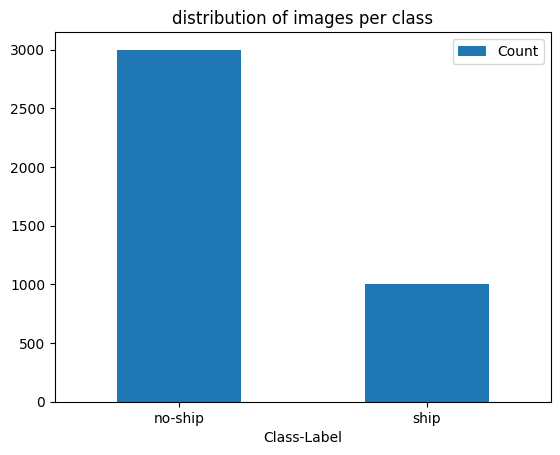

In [ ]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

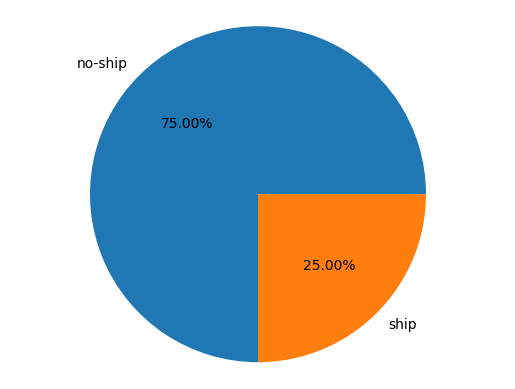

In [ ]:
plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal');

Data AUGMENTATION techniques are applied during the training process

Data augmentation involves applying random transformations to the training data, such as rotation, zooming, flipping, and shifting, to artificially increase the diversity of the training set. This can be beneficial for improving the generalization and robustness of the model.

In [ ]:
AUGMENTATION = True

In [ ]:
def augment_add(images, seq, labels):

    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):

        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass

    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)

    return (augmented_images, augmented_labels)
    pass

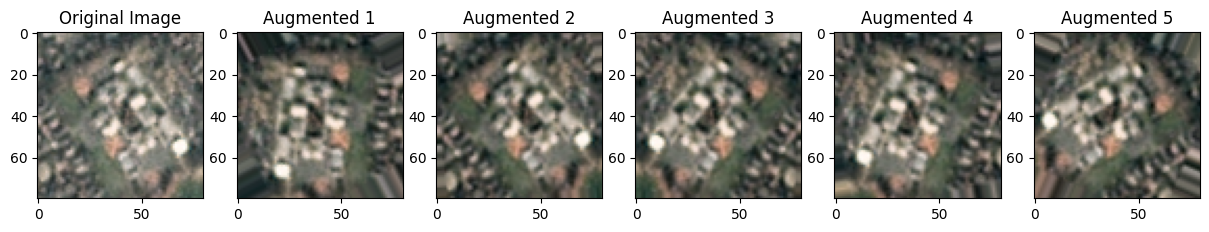

In [ ]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have a directory 'archive (1)' in your drive containing 'no_ship' and 'ship' folders
dataset_path = '/content/drive/MyDrive/archive (1)'

# Ensure the specified directory exists and contains image files
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Directory not found: {dataset_path}")

# List all files in the 'no_ship' folder
no_ship_folder = os.path.join(dataset_path, 'no-ship')
ship_folder = os.path.join(dataset_path, 'ship')

# Ensure the 'no_ship' and 'ship' folders exist
if not os.path.exists(no_ship_folder) or not os.path.exists(ship_folder):
    raise FileNotFoundError("Required folders not found within the specified directory.")

# List all files in the 'no_ship' and 'ship' folders
all_no_ship_images = [os.path.join(no_ship_folder, img) for img in os.listdir(no_ship_folder) if img.endswith(('.jpg', '.png'))]
all_ship_images = [os.path.join(ship_folder, img) for img in os.listdir(ship_folder) if img.endswith(('.jpg', '.png'))]

# Select a sample image from the 'no_ship' folder for demonstration
sample_image_path = all_no_ship_images[0]

# Load the sample image
sample_img = image.load_img(sample_image_path)
sample_img_array = image.img_to_array(sample_img)
sample_img_array = sample_img_array.reshape((1,) + sample_img_array.shape)  # Add batch dimension for flow method

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(rotation_range=30, horizontal_flip=True)

# Generate augmented images
augmented_images = []
for _ in range(5):  # Generate 5 augmented versions
    augmented_batch = datagen.flow(sample_img_array, batch_size=1)
    augmented_image = augmented_batch[0][0]
    augmented_images.append(augmented_image)

# Display the original and augmented images
plt.figure(figsize=(15, 5))

# Display the sample image
plt.subplot(1, 6, 1)
plt.imshow(sample_img)
plt.title('Original Image')

# Display the augmented images
for i in range(len(augmented_images)):
    plt.subplot(1, 6, i + 2)
    plt.imshow(image.array_to_img(augmented_images[i]))
    plt.title(f'Augmented {i + 1}')

plt.show()


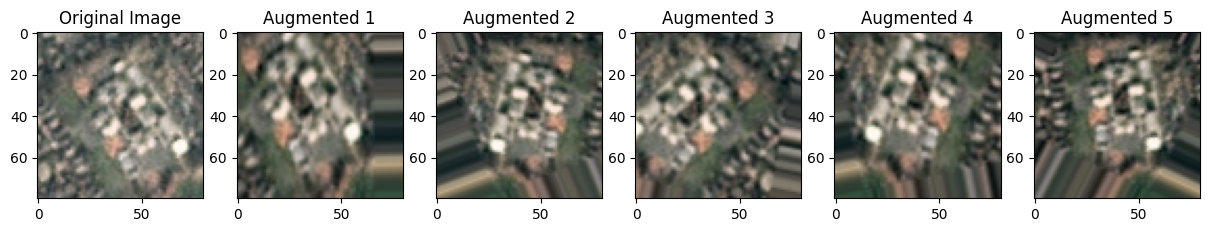

In [ ]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have a directory 'archive (1)' in your drive containing 'no_ship' and 'ship' folders
dataset_path = '/content/drive/MyDrive/archive (1)'

# Ensure the specified directory exists and contains image files
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Directory not found: {dataset_path}")

# List all files in the 'no_ship' folder
no_ship_folder = os.path.join(dataset_path, 'no-ship')
ship_folder = os.path.join(dataset_path, 'ship')

# Ensure the 'no_ship' and 'ship' folders exist
if not os.path.exists(no_ship_folder) or not os.path.exists(ship_folder):
    raise FileNotFoundError("Required folders not found within the specified directory.")

# List all files in the 'no_ship' and 'ship' folders
all_no_ship_images = [os.path.join(no_ship_folder, img) for img in os.listdir(no_ship_folder) if img.endswith(('.jpg', '.png'))]
all_ship_images = [os.path.join(ship_folder, img) for img in os.listdir(ship_folder) if img.endswith(('.jpg', '.png'))]

# Select a sample image from the 'no_ship' folder for demonstration
sample_image_path = all_no_ship_images[0]

# Load the sample image
sample_img = image.load_img(sample_image_path)
sample_img_array = image.img_to_array(sample_img)
sample_img_array = sample_img_array.reshape((1,) + sample_img_array.shape)  # Add batch dimension for flow method

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
augmented_images = []
for _ in range(5):  # Generate 5 augmented versions
    augmented_batch = datagen.flow(sample_img_array, batch_size=1)
    augmented_image = augmented_batch[0][0]
    augmented_images.append(augmented_image)

# Display the original and augmented images
plt.figure(figsize=(15, 5))

# Display the sample image
plt.subplot(1, 6, 1)
plt.imshow(sample_img)
plt.title('Original Image')

# Display the augmented images
for i in range(len(augmented_images)):
    plt.subplot(1, 6, i + 2)
    plt.imshow(image.array_to_img(augmented_images[i]))
    plt.title(f'Augmented {i + 1}')

plt.show()


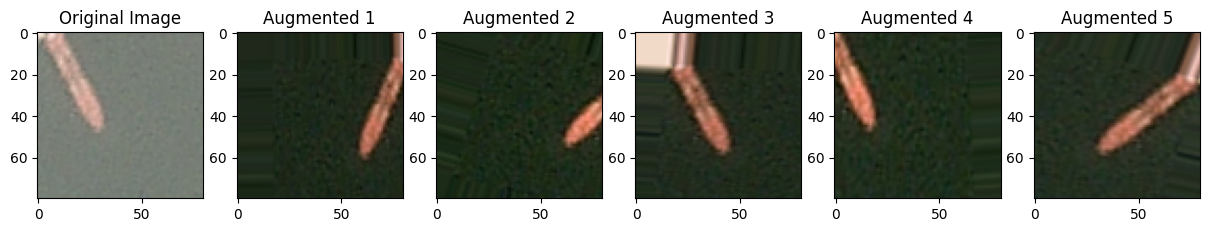

In [ ]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have a directory 'archive (1)' in your drive containing 'no_ship' and 'ship' folders
dataset_path = '/content/drive/MyDrive/archive (1)'

# Ensure the specified directory exists and contains image files
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Directory not found: {dataset_path}")

# List all files in the 'no_ship' folder
no_ship_folder = os.path.join(dataset_path, 'no-ship')
ship_folder = os.path.join(dataset_path, 'ship')

# Ensure the 'no_ship' and 'ship' folders exist
if not os.path.exists(no_ship_folder) or not os.path.exists(ship_folder):
    raise FileNotFoundError("Required folders not found within the specified directory.")

# List all files in the 'no_ship' and 'ship' folders
all_no_ship_images = [os.path.join(no_ship_folder, img) for img in os.listdir(no_ship_folder) if img.endswith(('.jpg', '.png'))]
all_ship_images = [os.path.join(ship_folder, img) for img in os.listdir(ship_folder) if img.endswith(('.jpg', '.png'))]

# Select the 10th image from the 'no_ship' folder for demonstration
sample_image_path = all_no_ship_images[2438]

# Load the sample image
sample_img = image.load_img(sample_image_path)
sample_img_array = image.img_to_array(sample_img)
sample_img_array = sample_img_array.reshape((1,) + sample_img_array.shape)  # Add batch dimension for flow method

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
augmented_images = []
for _ in range(5):  # Generate 5 augmented versions
    augmented_batch = datagen.flow(sample_img_array, batch_size=1)
    augmented_image = augmented_batch[0][0]
    augmented_images.append(augmented_image)

# Display the original and augmented images
plt.figure(figsize=(15, 5))

# Display the sample image
plt.subplot(1, 6, 1)
plt.imshow(sample_img)
plt.title('Original Image')

# Display the augmented images
for i in range(len(augmented_images)):
    plt.subplot(1, 6, i + 2)
    plt.imshow(image.array_to_img(augmented_images[i]))
    plt.title(f'Augmented {i + 1}')

plt.show()


In [ ]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True)

In [ ]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])

4000it [00:04, 931.77it/s]  


In [ ]:
images.shape, labels.shape

((6000, 48, 48, 3), (6000,))

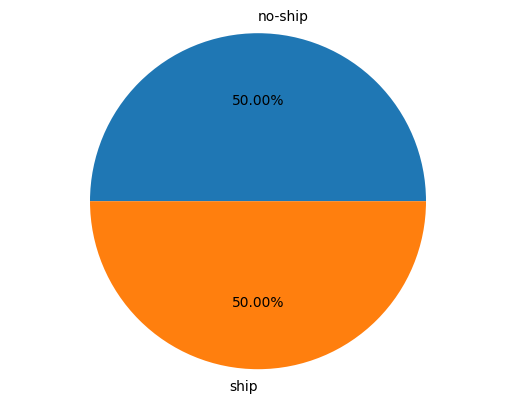

In [ ]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True)

    plt.pie(count,
           explode=(0,0),
           labels=class_names,
           autopct="%1.2f%%")
    plt.axis('equal');

In [ ]:
labels = to_categorical(labels)

Setting a seed ensures reproducibility in random operations. If the seed is the same, the random sequence will be identical across runs, which can be important for debugging and achieving consistent results.

In [ ]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

TOTAL (6020)

training (70%)
validation (20%)
test (10%)

In [ ]:
total_count = len(images)
total_count


train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((4200, 48, 48, 3), (1200, 48, 48, 3), (600, 48, 48, 3))

WHEN ENCOUNTERED WITH CLASS IMBALANCE

In [ ]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0)

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

In [ ]:
def conv_block(X,k,filters,stage,block,s=2):

    conv_base_name = 'conv_' + str(stage)+block+'_branch'
    bn_base_name = 'bn_'+str(stage)+block+"_branch"

    F1 = filters

    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same',name=conv_base_name+'2a')(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)

    return X
    pass

In [ ]:
def basic_model(input_shape,classes):

    X_input = Input(input_shape)

    X = ZeroPadding2D((5,5))(X_input)

    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X)
    X = BatchNormalization(name='bn_conv1')(X)

    # stage 2
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 3
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 4
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#   Output Layer
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Dropout(0.5)(X)

    X = Dense(128)(X)
    X = Activation("relu")(X)

    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC')

    return model
    pass


In [ ]:
model = basic_model(input_shape=(48,48,3),classes=2)

In [ ]:
plot_model(model,to_file='basic_model.png')
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 58, 58, 3)         0         
 g2D)                                                            
                                                                 
 conv1 (Conv2D)              (None, 29, 29, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizati  (None, 29, 29, 16)        64        
 on)                                                             
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 29, 29, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNorma  (None, 29, 2

In [ ]:
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

In [ ]:
epochs = 50 #the number of times the entire training dataset is passed through the neural network
batch_size = 16 #number of samples that are used in the each iteration

history = model.fit(train_images,train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(val_images,val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs]
#                    class_weight=classWeight # Uncomment if AUGMENTATION is set to FALSE
                   )

Epoch 1/50
262/262 [==============================] - ETA: 0s - loss: 0.3967 - accuracy: 0.8249
Epoch 1: val_accuracy improved from -inf to 0.84250, saving model to model_weights.h5
262/262 [==============================] - 16s 50ms/step - loss: 0.3967 - accuracy: 0.8249 - val_loss: 0.3766 - val_accuracy: 0.8425
Epoch 2/50
  3/262 [..............................] - ETA: 9s - loss: 0.4055 - accuracy: 0.8235

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


262/262 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.9252
Epoch 2: val_accuracy improved from 0.84250 to 0.94583, saving model to model_weights.h5
262/262 [==============================] - 12s 47ms/step - loss: 0.1807 - accuracy: 0.9252 - val_loss: 0.1418 - val_accuracy: 0.9458
Epoch 3/50
261/262 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9455
Epoch 3: val_accuracy improved from 0.94583 to 0.97000, saving model to model_weights.h5
262/262 [==============================] - 11s 42ms/step - loss: 0.1431 - accuracy: 0.9457 - val_loss: 0.0873 - val_accuracy: 0.9700
Epoch 4/50
262/262 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9547
Epoch 4: val_accuracy improved from 0.97000 to 0.97583, saving model to model_weights.h5
262/262 [==============================] - 12s 46ms/step - loss: 0.1244 - accuracy: 0.9547 - val_loss: 0.0746 - val_accuracy: 0.9758
Epoch 5/50
261/262 [============================>.] - ETA


Epoch 48: val_accuracy improved from 0.98917 to 0.99000, saving model to model_weights.h5
262/262 [==============================] - 5s 18ms/step - loss: 0.0130 - accuracy: 0.9959 - val_loss: 0.0445 - val_accuracy: 0.9900


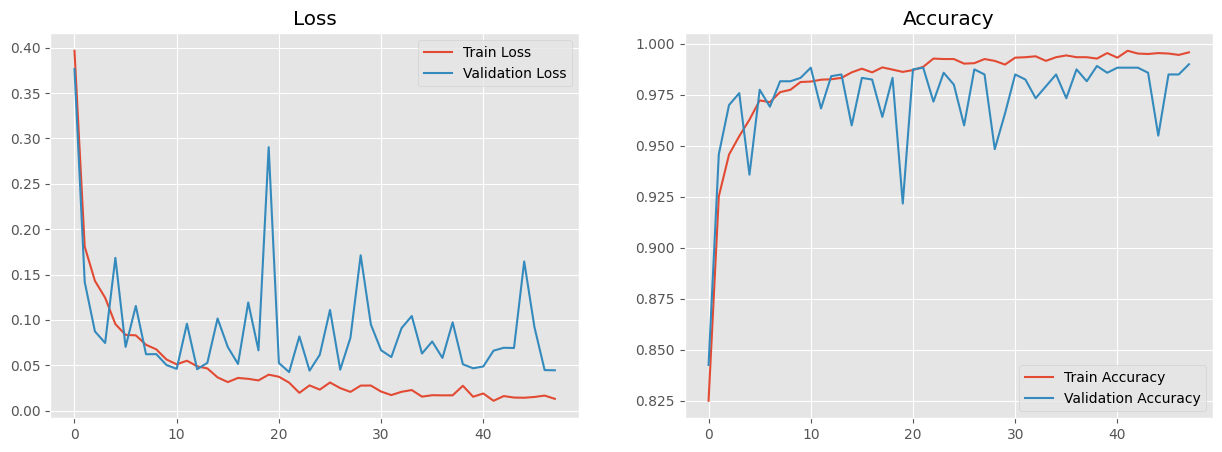

In [ ]:
show_final_history(history)

In [ ]:
val_pred = model.predict(val_images)
val_pred = np.argmax(val_pred,axis=1)
val_pred.shape

38/38 [==============================] - 1s 25ms/step


(1200,)

ASSESS THE PERFROMANCE OF THE DATASET

True Negatives (TN):

Instances correctly predicted as "no ship": 1.00 (100% precision for "no ship")
False Positives (FP):

Instances incorrectly predicted as "ship" when the true label is "no ship": 0.00
False Negatives (FN):

Instances incorrectly predicted as "no ship" when the true label is "ship": 0.04
True Positives (TP):

Instances correctly predicted as "ship": 0.96 (96% precision for "ship")

<Figure size 640x480 with 0 Axes>

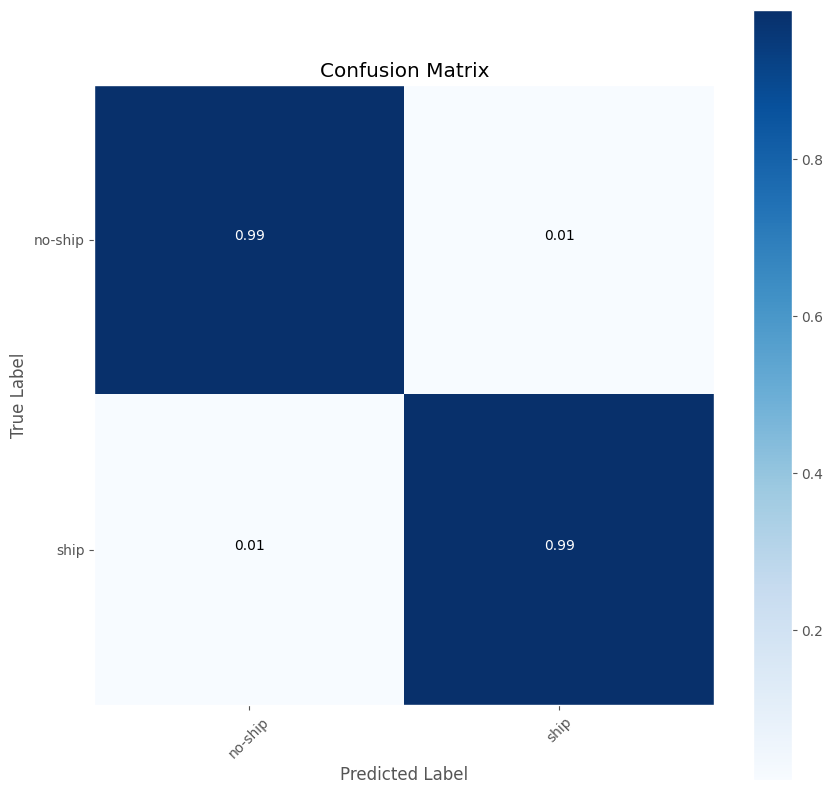

In [ ]:
val_actual = np.argmax(val_labels,axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

making predictions on test set using training set

In [ ]:
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape

19/19 [==============================] - 0s 17ms/step


(600,)

<Figure size 640x480 with 0 Axes>

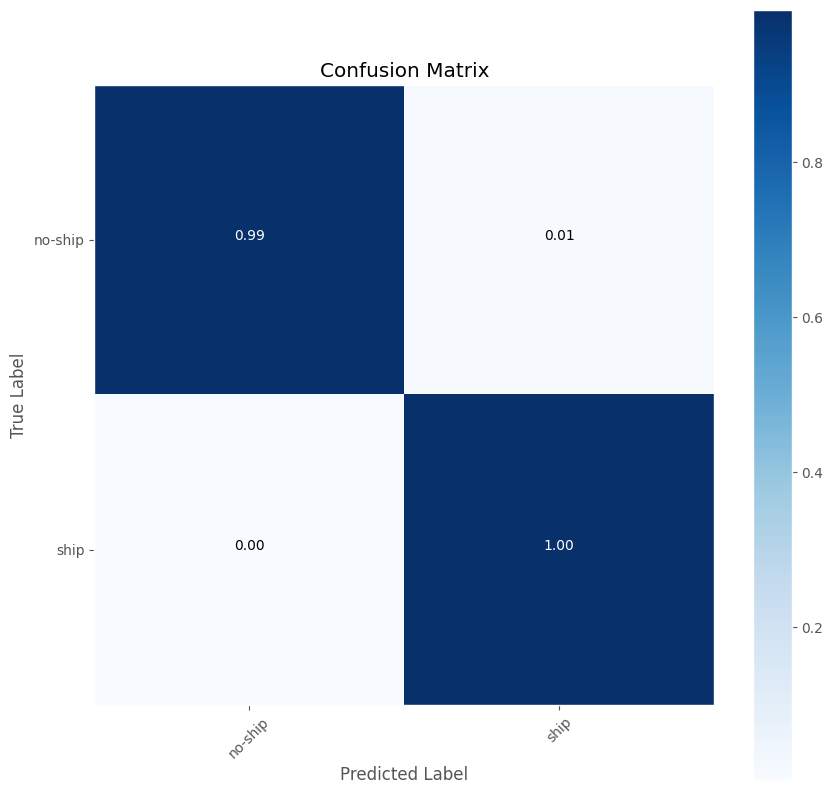

In [ ]:
test_actual = np.argmax(test_labels,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()

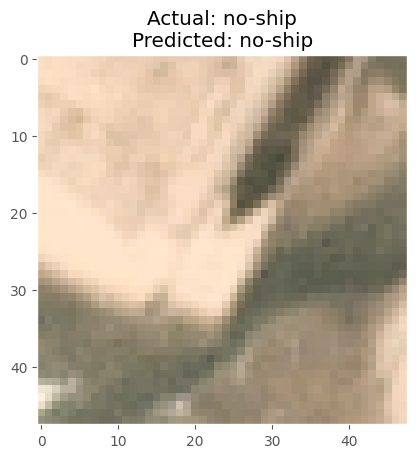

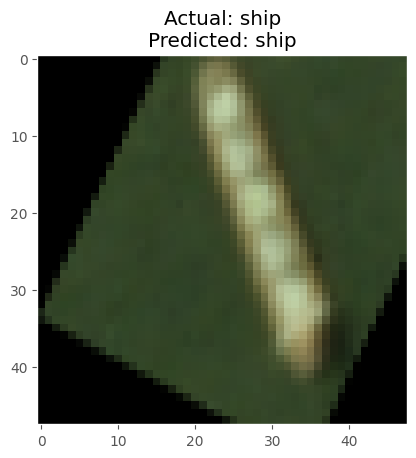

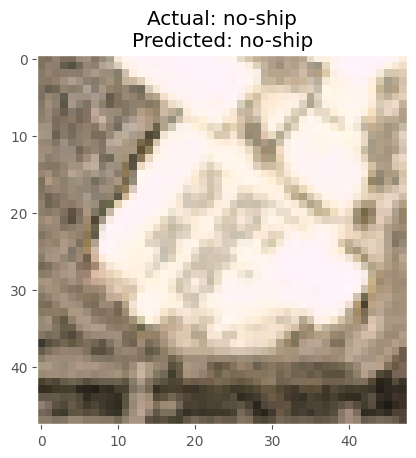

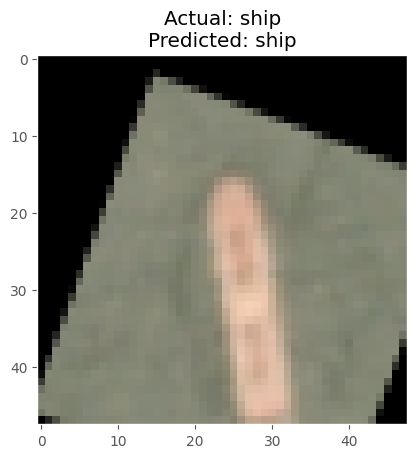

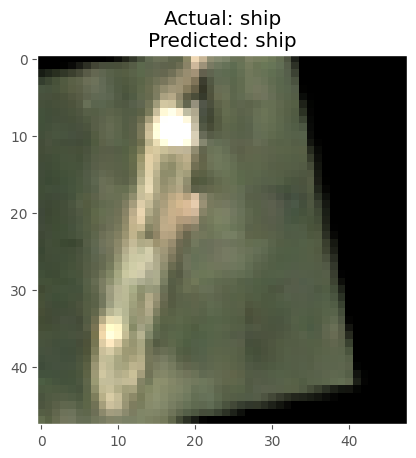

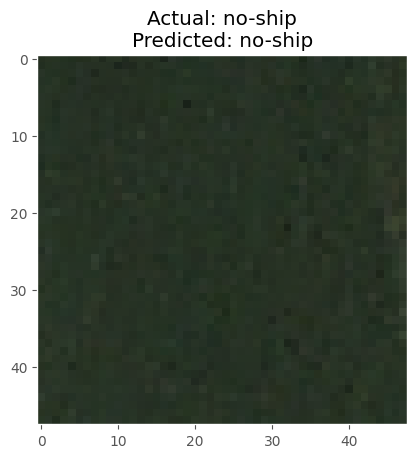

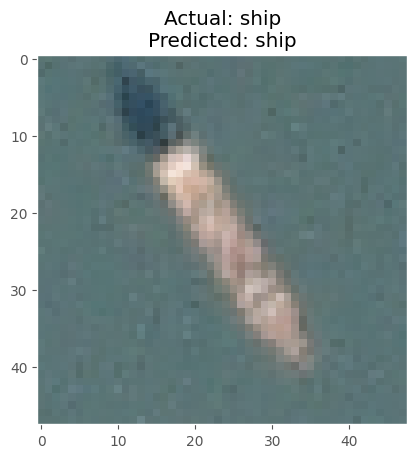

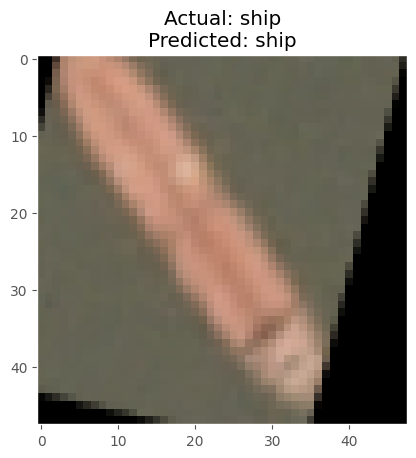

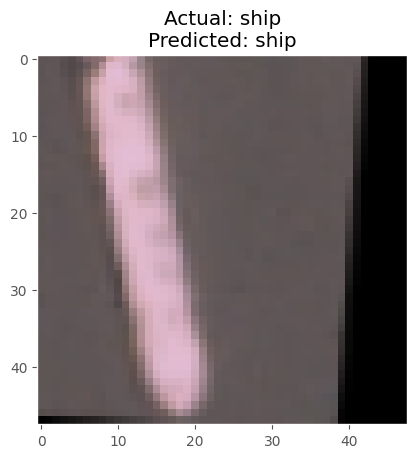

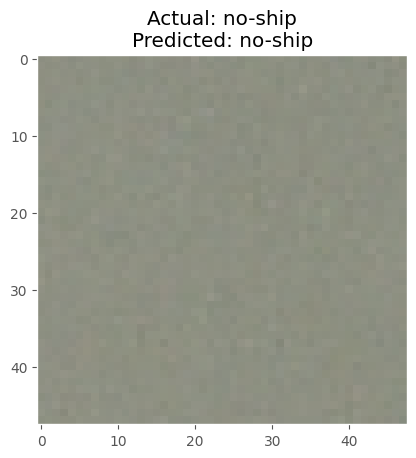

In [ ]:
rnd_idx = random.sample(range(0,400),10)

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):

    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass

In [ ]:
model.save("ship-model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!cp ship-model.h5 /content/drive/MyDrive